# Problem Statement

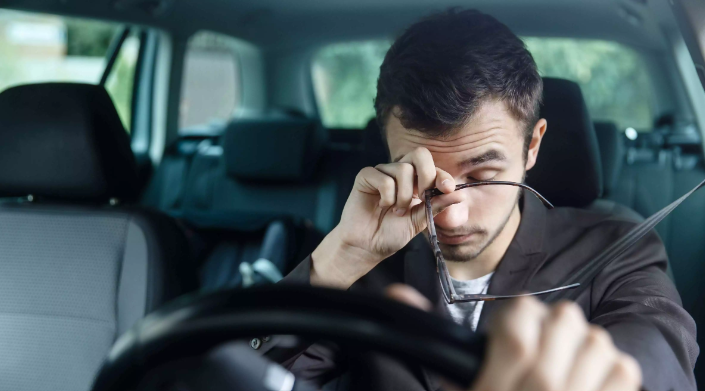

In [ ]:
from IPython.display import Image, display

# Replace 'your_image_filename.jpg' with the actual filename of the uploaded image
image_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/DDD.png'

# Display the image
display(Image(image_path))


### Import all dependencies

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import time
from tensorflow.keras.layers import Input,Dense,Conv2D,Conv3D,DepthwiseConv2D,SeparableConv2D,Conv3DTranspose
from tensorflow.keras.layers import Flatten,MaxPool2D,AvgPool2D,GlobalAvgPool2D,UpSampling2D,BatchNormalization
from tensorflow.keras.layers import Concatenate,Add,Dropout,ReLU,Lambda,Activation,LeakyReLU,PReLU
import tensorflow.keras.backend as K
from IPython.display import SVG
from tensorflow.keras.preprocessing import image
from time import time

### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
drowsy_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Drowsy 1'
nondrowsy_path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Non Drowsy 2'

# Use glob to grab images from path .jpg or jpeg
drowsy_files = glob(drowsy_path + '/*')
nondrowsy_files = glob(nondrowsy_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Labels
drowsy_labels = []
nondrowsy_labels = []

drowsy_images=[]
nondrowsy_images=[]

import cv2

for i in range(len(drowsy_files)):
  image = cv2.imread(drowsy_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  drowsy_images.append(image)
  drowsy_labels.append('drowsy')
for i in range(len(nondrowsy_files)):
  image = cv2.imread(nondrowsy_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nondrowsy_images.append(image)
  nondrowsy_labels.append('Nondrowsy')

### Visualize First 40 Images from Data set

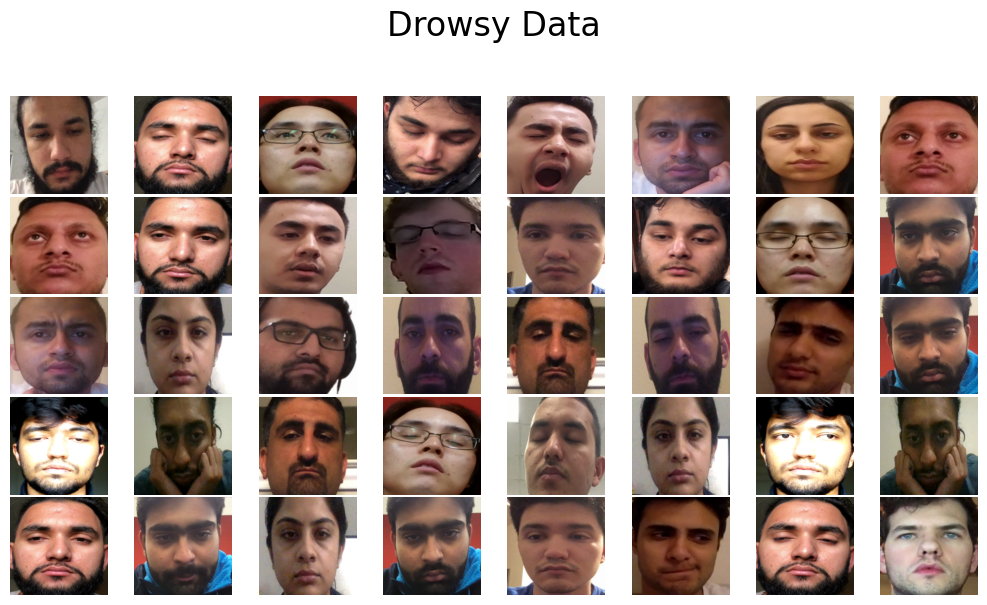

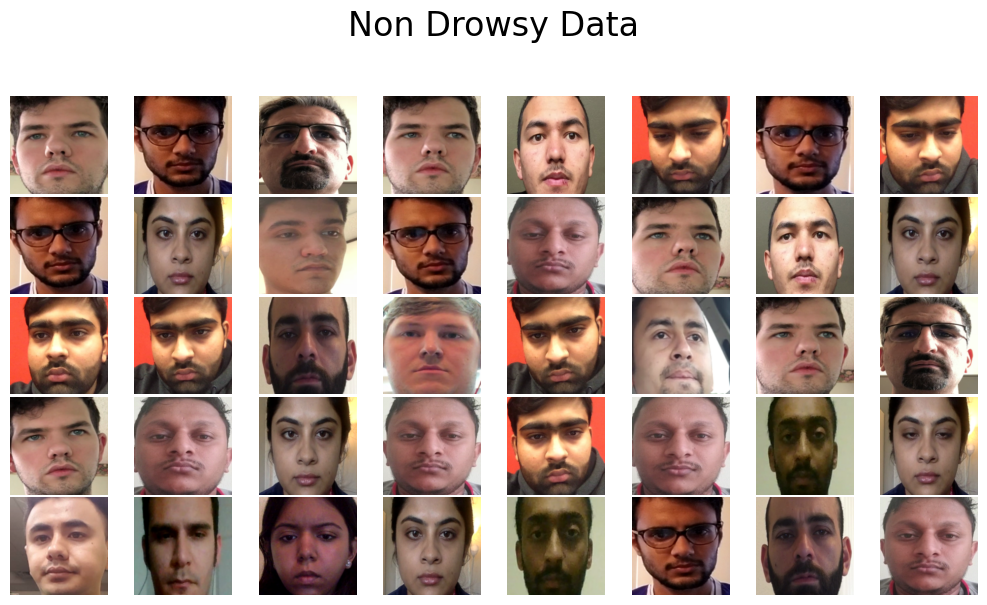

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(drowsy_images, 'Drowsy Data')
plot_images(nondrowsy_images, 'Non Drowsy Data')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# normalize to interval of [0,1]
drowsy_images = np.array(drowsy_images) / 255
nondrowsy_images = np.array(nondrowsy_images) / 255

NameError: ignored

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
drowsy_x_train, drowsy_x_test, drowsy_y_train, drowsy_y_test = train_test_split(
    drowsy_images, drowsy_labels, test_size=0.2)
nondrowsy_x_train, nondrowsy_x_test, nondrowsy_y_train, nondrowsy_y_test = train_test_split(
    nondrowsy_images, nondrowsy_labels, test_size=0.2)


X_train = np.concatenate((nondrowsy_x_train, drowsy_x_train), axis=0)
X_test = np.concatenate((nondrowsy_x_test, drowsy_x_test), axis=0)
y_train = np.concatenate((nondrowsy_y_train, drowsy_y_train), axis=0)
y_test = np.concatenate((nondrowsy_y_test, drowsy_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

In [ ]:
plot_images(drowsy_x_train, 'X_train')
plot_images(drowsy_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing drowsy and Nondrowsy for X_train and X_test

### **Building and Visualizing model**

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)

Epoch 1/100
7/7 [==============================] - 7s 577ms/step - loss: 2.1428 - accuracy: 0.5265 - val_loss: 1.7901 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 3s 382ms/step - loss: 0.9615 - accuracy: 0.6062 - val_loss: 0.4396 - val_accuracy: 0.7759
Epoch 3/100
7/7 [==============================] - 3s 382ms/step - loss: 0.7696 - accuracy: 0.6549 - val_loss: 0.2171 - val_accuracy: 0.9138
Epoch 4/100
7/7 [==============================] - 3s 388ms/step - loss: 0.6966 - accuracy: 0.7168 - val_loss: 0.4562 - val_accuracy: 0.7931
Epoch 5/100
7/7 [==============================] - 3s 381ms/step - loss: 0.5974 - accuracy: 0.7611 - val_loss: 0.1660 - val_accuracy: 0.9483
Epoch 6/100
7/7 [==============================] - 3s 381ms/step - loss: 0.5432 - accuracy: 0.7788 - val_loss: 0.2075 - val_accuracy: 0.9138
Epoch 7/100
7/7 [==============================] - 3s 438ms/step - loss: 0.5127 - accuracy: 0.7920 - val_loss: 0.1374 - val_accuracy: 0.9483
Epoch 8/100
7

In [ ]:
model.save('resnet_drowsiness.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save_weights('resnetweights_drowsiness.hdf5')

In [ ]:
model = load_model('resnet_drowsiness.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

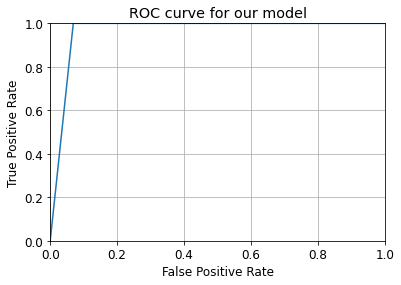

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        29
           1       0.94      1.00      0.97        29

    accuracy                           0.97        58
   macro avg       0.97      0.97      0.97        58
weighted avg       0.97      0.97      0.97        58



### **Accuracy and Loss Plots**

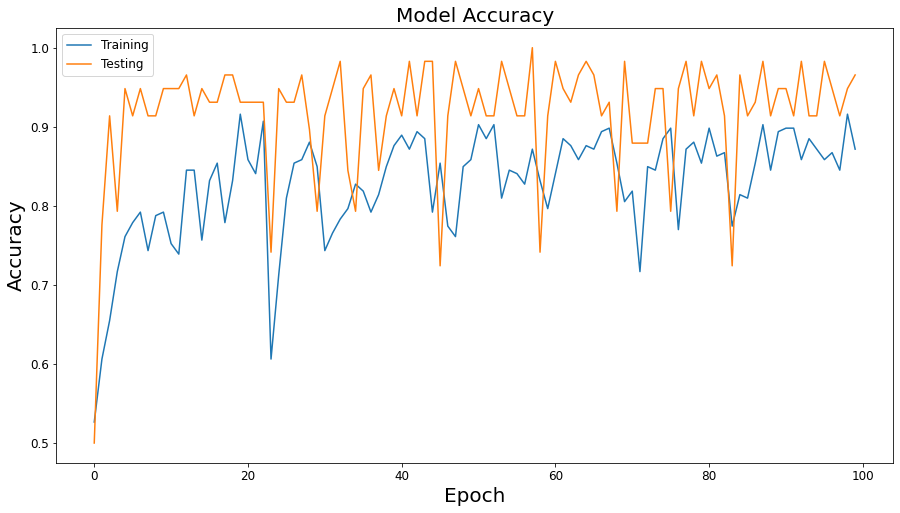

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_accuracy.png')
plt.show()


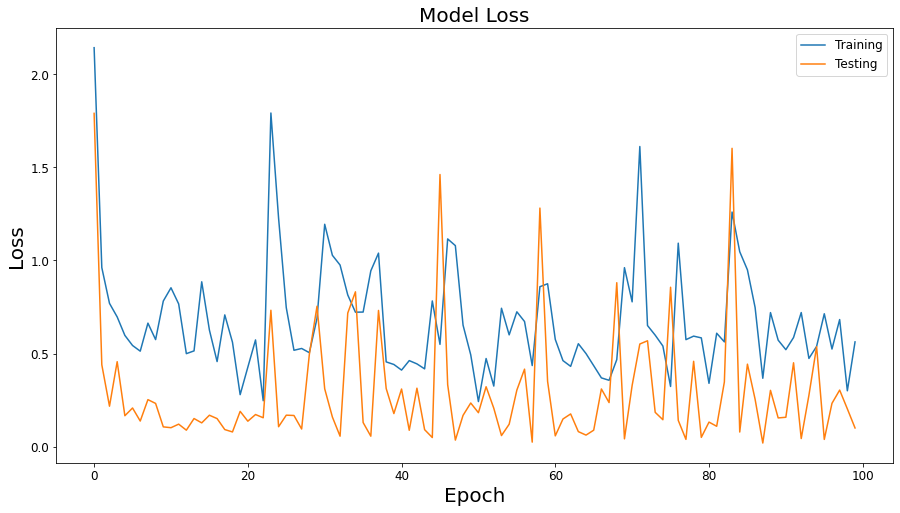

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_chest_loss.png')
plt.show()

In [ ]:
plt.figure(figsize=(5,7))
plt.boxplot(history.history['accuracy'])
plt.title("Resnet Accuracy Box Plot",fontsize=20)
plt.show()